# Import Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import string

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models import Word2Vec, KeyedVectors
# from word2vec import load_word2vec_format
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from statistics import mean

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import nltk 
nltk.download('punkt')

ModuleNotFoundError: No module named 'gensim'

# Read Data from CSV files

In [2]:
train_text = pd.read_csv("include/train.csv", index_col=False)
train_text.reset_index(drop=True)
test_text = pd.read_csv("include/test.csv", index_col=False)
sample_submission = pd.read_csv("include/sample_submission.csv", index_col=False)
test_labels = pd.read_csv("include/test_labels.csv", index_col=False)

train_text.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
X = train_text['comment_text'].values
y = train_text.drop(['id'], axis=1)
y = y.drop(['comment_text'], axis=1)
y_vals = y.to_numpy()
X_val = test_text['comment_text'].values


In [4]:
#Looking at the distribution of traget variables
y_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
train_text[y_cols].apply(pd.Series.value_counts, args = (True, True, False, None, False))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.904156,0.990004,0.947052,0.997004,0.950636,0.991195
1,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805


# Plot training data labels

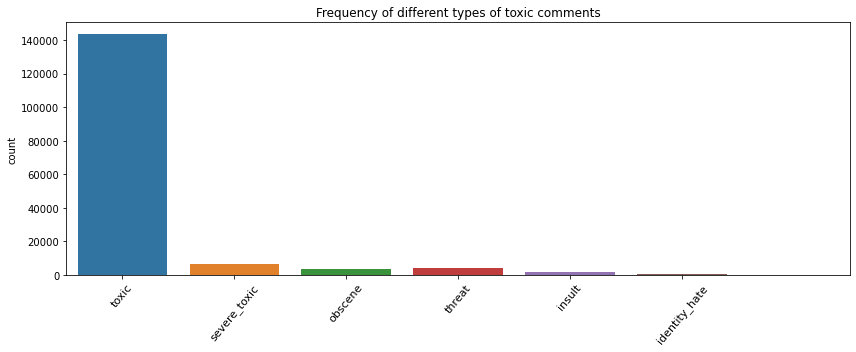

In [5]:
# fig, axes = plt.subplots(figsize = (32,8))
fig, axes = plt.subplots(figsize = (12,5))
sns.countplot(y.sum(axis = 1))
# NOTE: axis = 1 adds everything along columns and axis = 0 adds everything along rows
axes.set_xticks(range(6)) # Have to do this to work around a bug
axes.set_xticklabels(y.columns, rotation = 50, ha = "center", fontsize = 11)
plt.title("Frequency of different types of toxic comments")
plt.tight_layout()
plt.show()

# Clean data

In [6]:
# Remove punctuation marks and digits
# Stop words remoe words such as: in, the, so, of etc. that don't help us determine the y labels
def preprocess(texts):
    #importing stop words like in, the, of so that these can be removed from texts
    #as these words dont help in determining the classes(Whether a sentence is toxic or not)
    mystopwords = set(stopwords.words("english"))
    def clean(tokens):
        #Nested function that lowercases, removes stopwords and digits from a list of tokens
        return [token.lower() for token in tokens if token not in mystopwords and not token.isdigit()
               and token not in punctuation]
    #This return statement below uses the above function and tokenizes output further. 
    return [clean(word_tokenize(text)) for text in tqdm(texts)]

In [7]:
#Preprocess both for training and test data
train_texts_processed = preprocess(X)
test_texts_processed = preprocess(X_val)

# Load pretrained embeddings

In [8]:
# Load pretrained embeddings from Gensim (Generate Similar) library. 
# It has pretrained embeddings for Google News dataset
w2v_model = KeyedVectors.load('include/GoogleNews-vectors-negative300.gensim')

# Create Embeddings for the words in the dataset using the pretrained embedding vector

In [9]:
# each sentence is a list of words and all the sentences are inside another list
def embeddings(list_of_lists, dimension, w2v_embeddings):
    #set the zero-vector to the size of the dimension. Dimension = 300 (Google News Model's embedding vector dimension is 300)
    zeros_vector = np.zeros(dimension)
    features = []
    missing = set() # when there are missing words in a sentence
    missing_sentences = set() # when all the words in a sentence are missing
    
    # Go through each sentence
    for tokens in tqdm(list_of_lists):
        # Initially set 0s to the embedding vector of the sentence
        features_of_sentence = zeros_vector
        # set the count of the number of words in the embedding for this sentence to 0
        count_of_words = 0
        # Go through each word in a sentence
        for token in tokens:
            # Check if the word is in the word to vec embedding vector
            if token in w2v_embeddings:
                # add the vector of the word to the vector of the sentence
                features_of_sentence += w2v_embeddings[token]
                count_of_words += 1 # increase count by 1 since there is an embedding in the w2v model
            # Else assign the missing word to the missing set 
            else:
                missing.add(token)
        # If no words in the sentence have embeddings in the w2v model
        if count_of_words == 0:
            # Assign all zeroes vector for the sentence
            features.append(features_of_sentence)
            # put the missing sentence (all words in the sentence have no pretrained embedding) to missing_sentenses
            missing_sentences.add(' '.join(tokens))
        # Else, take the averageof the values of the embeddings for each word to get the embeddigns for the entire sentence
        else:
            features.append(features_of_sentence/count_of_words)
    return features, missing, missing_sentences

In [10]:
#Embeddings for the train dataset
training_data_vectors, missing, missing_sentences = embeddings(train_texts_processed, 300, w2v_model)

# Train test split, seperate a fraction of the training data to test on
train_data, val_data, train_output, val_output = train_test_split(training_data_vectors, y_vals)

# create a logistic regression model, with multi output classifier since we have 6 output labels
logistic_regression = MultiOutputClassifier(LogisticRegression(class_weight = 'unbalanced', max_iter = 3000))
logistic_regression = logistic_regression.fit(train_data, train_output)

target_prediction = logistic_regression.predict(val_data)
# print("Prediction:", target_prediction)
# print("Actual", val_output)

prediction_accuracy = accuracy_score(val_output, target_prediction)
print("The accuracy score on a small section of the training data is: ", prediction_accuracy)


Prediction: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
Actual [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
The accuracy score on a small section of the training data is:  0.8968741383200061


# Define function to train the model and calculate AUC

In [11]:
def train_auc(dimension, model):
    # call the function above to create embeddings for the words in the training dataset
    training_data_vectors, missing, missing_sentences = embeddings(train_texts_processed, 300, w2v_model)
    
    # split the embedding vector along with the output variable to form training set and validation set
    train_data, val_data, train_output, val_output = train_test_split(training_data_vectors, y_vals)
    
    # create a logistic regression model, with multi output classifier since we have 6 output labels
    logistic_regression = MultiOutputClassifier(LogisticRegression(class_weight = 'balanced', max_iter = 3000))
    logistic_regression = logistic_regression.fit(train_data, train_output)
    
    # create a copy of the actual output values for calculating the accuracy later
    y_output = val_output
    
    # predict the probability of the validation dataset by logistic regression model
    prediction = logistic_regression.predict_proba(val_data)
    y_predict = np.transpose(np.array(prediction)[:,:,1])
    
    # calcuate the ROC and AUC for the prediction
    aucs = []
    # calculate for each column
    for col in range(y_output.shape[1]):
        score = roc_auc_score(y_output[:,col], y_predict[:,col])
        aucs.append(score)
    mean_auc = mean(aucs)
    
    return mean_auc, logistic_regression # return the model since we need it to use on the test data

# Train the model using the Google news Word to Vec embeddings

In [12]:
mean_auc, logistic_regression = train_auc(300, w2v_model)
print("The mean AUC for logistic regression model is: ", mean_auc)


The mean AUC for logistic regression model is:  0.580875208110089


# Predicting and submitting on test data

In [13]:
# create embeddings for the test data
test_data_vectors, missing, missing_sentences  = embeddings(test_texts_processed, 300, w2v_model)
# test_vectors, _, _ = embedding_feats(test_texts_processed, 300, w2v_google_news)

# Use the created logistic regression model to get the output probabilities
prediction = logistic_regression.predict_proba(test_data_vectors)
y_prediction = np.transpose(np.array(prediction)[:,:,1])
# print(y_prediction)

# write the output into a CSV file

# Merge the test_text and the sample submission files
df_test = pd.merge(test_text, sample_submission, on = 'id')
# Create the y-labels
y_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# Input the prediction values into the dataframe
df_test[y_cols] = y_prediction
# drop the comment_text column as it is not a part of the sample submission
df_test.drop(['comment_text'], axis = 1, inplace = True)
# Write the values in the dataframe into a CSV file
df_test.to_csv("pipeline2.csv", index = False)
print("Data saved in the csv file")


Data saved in the csv file
